# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

import os
import pandas as pd
os.getcwd()

'C:\\Users\\PML\\Documents\\EPFL 2017-2018\\ADA_ENPantouFLeS\\HW1'

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [2]:
#First, for every country, we create a frame with the information we need
#We format them so that they are consistent
#Then we merge the three frames
#We chose to take the cumulative data as it is the data we could consistently find in every record
#We then take one value per month to get the cumulative number of cases/deaths at this month
#Value that we substract by the previous one to get the number of cases/deaths during this month
#Finally we divide this value by 30 to get the daily average of this month
#We observe unexpected value nonetheless
    
#creation of the subframe for guinea
guiT = []
for file in os.listdir(DATA_FOLDER + "/ebola/guinea_data"):
    if file.endswith(".csv"):
        guiT += [pd.read_csv(DATA_FOLDER + '/ebola/guinea_data/' + file)]
gui = pd.concat(guiT)
gui = gui[["Date", "Description", "Totals"]]

gui_death = gui[gui.Description.isin(["Total deaths (confirmed + probables + suspects)"])]
gui_death = gui_death.reset_index()
gui_death = gui_death[["Date","Totals"]]
gui_death.columns = ["Month","Deaths"]

gui_case = gui[gui.Description.isin(["Cumulative (confirmed + probable + suspects)"])]
gui_case = gui_case.reset_index()
gui_case = gui_case[["Date","Totals"]]
gui_case.columns = ["Month","Case"]

gui = pd.merge(gui_case, gui_death)
gui["Month"] = gui["Month"].map(lambda x:int(x.split("-")[1]))

#creation of the subframe for liberia
libT = []
for file in os.listdir(DATA_FOLDER + "/ebola/liberia_data"):
    if file.endswith(".csv"):
        libT += [pd.read_csv(DATA_FOLDER + '/ebola/liberia_data/' + file)]
lib = pd.concat(libT)
lib = lib[["Date", "Variable", "National"]]
lib.columns = ["Date", "Description", "Totals"]

lib_death = lib[lib.Description.isin(["Total death/s in confirmed, probable, suspected cases","Total death/s in confirmed, \r\n probable, suspected cases"])]
lib_death = lib_death.reset_index()
lib_death = lib_death[["Date","Totals"]]
lib_death.columns = ["Month","Deaths"]

lib_case = lib[lib.Description.isin(["Cumulative confirmed, probable and suspected cases"])]
lib_case = lib_case.reset_index()
lib_case = lib_case[["Date","Totals"]]
lib_case.columns = ["Month","Case"]

lib_case2 = lib[lib.Description.isin(["Total suspected cases","Total probable cases","Total confirmed cases"])]
lib_case2 = lib_case2.reset_index()
lib_case2 = lib_case2[["Date","Totals"]]
lib_case2 = lib_case2.fillna(0)
lib_case2['Totals'] = lib_case2['Totals'].map(lambda x: int(float("".join(str(x).split(',')))))
lib_case2 = lib_case2.groupby("Date").agg(sum)
lib_case2 = lib_case2.reset_index()
lib_case2.columns = ["Month","Case"]

lib_case = pd.concat([lib_case, lib_case2])

lib = pd.merge(lib_case, lib_death)
lib["Month"] = lib["Month"].map(lambda x:int(x.split("/")[0]))


#creation of the subframe for sl
slT = []
for file in os.listdir(DATA_FOLDER + "/ebola/sl_data"):
    if file.endswith(".csv"):
        slT += [pd.read_csv(DATA_FOLDER + '/ebola/sl_data/' + file)]
sl = pd.concat(slT)
sl = sl[["date", "variable", "National"]]
sl.columns = ["Date", "Description", "Totals"]

sl_death = sl[sl.Description.isin(["death_confirmed","death_suspected","death_probable"])]
sl_death = sl_death.reset_index()
sl_death = sl_death[["Date","Totals"]]
sl_death = sl_death.fillna(0)
sl_death['Totals'] = sl_death['Totals'].map(int)
sl_death = sl_death.groupby("Date").agg(sum)

sl_death.columns = ["Deaths"]

sl_case = sl[sl.Description.isin(["cum_confirmed","cum_suspected","cum_probable"])]
sl_case = sl_case.reset_index()
sl_case = sl_case[["Date","Totals"]]
sl_case = sl_case.fillna(0)
sl_case['Totals'] = sl_case['Totals'].map(lambda x: int(float("".join(str(x).split(',')))))
sl_case = sl_case.groupby("Date").agg(sum)
sl_case.columns = ["Case"]

sl = pd.concat([sl_case, sl_death], axis=1)
sl["Month"] = sl.index.map(lambda x:int(x.split("-")[1]))


DF = pd.concat([gui, lib, sl], keys=["gui", "lib", "sl"])
DF = DF.reset_index()
DF = DF[["level_0","Case","Deaths","Month"]]
DF.columns = ["Country","Case","Deaths","Month"]

DF_group = DF.groupby(['Country','Month']).agg(max)
DF_group = DF_group.reset_index()
DF_group.columns = ["Country","Month","Category","Average"]
DF_group["Average"] /= 30

#Transforming cumulative data into sequential
DF_group_bis = DF_group.copy()
DF_group_bis['Month'] += 1
DF_group_bis["Average"] *= -1
DF_group = pd.concat([DF_group, DF_group_bis[~DF_group_bis["Month"].isin(DF_group_bis.groupby(["Country"]).agg(max)["Month"])]])
DF_group.groupby(["Country","Month","Category"]).agg(sum)

Average
Country Month Category            
gui     9     Case       32.466667
              Deaths     23.800000
        10    Case        7.500000
              Deaths      0.833333
lib     6     Case        3.000000
              Deaths      1.633333
        7     Case        7.233333
              Deaths      3.200000
        8     Case       42.500000
              Deaths     24.666667
        9     Case       74.800000
              Deaths     39.100000
        10    Case       89.966667
              Deaths     22.633333
        11    Case      255.100000
              Deaths    139.366667
        12    Case        4.800000
              Deaths    -29.700000
sl      8     Case       39.666667
              Deaths     14.500000
        9     Case       41.733333
              Deaths      5.433333
        10    Case       72.300000
              Deaths     27.900000
        11    Case      236.966667
              Deaths     62.066667
        12    Case       38.800000
              Deaths      7.066667

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [3]:
#We merge all DataFrame using differents column for the numerical data contained in each of the 9 spredsheets
#And then add as a string all group and sample they were part of

#Loading metadata
meta_data = pd.read_excel(DATA_FOLDER + "/microbiome/metadata.xls")
meta_data.index = meta_data["BARCODE"]
meta_data = meta_data.fillna('NA')


#Loading data files
data_files = ["/microbiome/MID"+str(i) +  ".xls" for i in range(1,10)]

mid = [pd.read_excel(DATA_FOLDER + file_name,sheetname='Sheet 1', header=None) for file_name in data_files]
for i in range(len(mid)):
    mid[i].columns = ["Microbiome",str(i+1)]

#Combining data files
mid_comb = mid[0]
for i in range(1,len(mid)):
    mid_comb = pd.merge(mid_comb,mid[i],how='outer')

#For each row, we note all group and sample in which they appear in a string
mid_comb['Group'] = ''
mid_comb['Sample'] = ''

mid_comb.loc[(mid_comb['1'].notnull(),'Group')] += meta_data.loc['MID1']['GROUP']
mid_comb.loc[(mid_comb['1'].notnull(),'Sample')] += meta_data.loc['MID1']['SAMPLE']

for i in range(1,len(mid)):
   mid_comb.loc[(mid_comb[str(i+1)].notnull(),'Group')] += " " + meta_data.loc["MID" + str(i+1)]['GROUP']
   mid_comb.loc[(mid_comb[str(i+1)].notnull(),'Sample')] += " " + meta_data.loc["MID" + str(i+1)]['SAMPLE']

#Filling NaN with 'unknown' as required
mid_comb = mid_comb.fillna('unknown')
mid_comb.index = mid_comb["Microbiome"]

#Final DataFrame
mid_comb

,Microbiome,1,2,3,4,5,6,7,8,9,Group,Sample
Microbiome,,,,,,,,,,,,
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera","Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7,23,14,2,28,7,8,unknown,16,EXTRACTION CONTROL NEC 1 Control 1 NEC 2 Contr...,NA tissue tissue tissue tissue stool stool stool
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus","Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,2,unknown,unknown,3,2,1,unknown,unknown,EXTRACTION CONTROL NEC 1 Control 2 NEC 1 Contr...,NA tissue tissue stool stool
"Archaea ""Crenarchaeota"" Thermoprotei Sulfolobales Sulfolobaceae Stygiolobus","Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",3,10,4,unknown,14,5,5,1,6,EXTRACTION CONTROL NEC 1 Control 1 Control 2 N...,NA tissue tissue tissue stool stool stool stool
"Archaea ""Crenarchaeota"" Thermoprotei Thermoproteales Thermofilaceae Thermofilum","Archaea ""Crenarchaeota"" Thermoprotei Thermopro...",3,9,5,unknown,10,4,5,unknown,5,EXTRACTION CONTROL NEC 1 Control 1 Control 2 N...,NA tissue tissue tissue stool stool stool
"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Methanocellales Methanocellaceae Methanocella","Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",7,9,7,1,17,12,18,unknown,14,EXTRACTION CONTROL NEC 1 Control 1 NEC 2 Contr...,NA tissue tissue tissue tissue stool stool stool
"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Methanosarcinales Methanosarcinaceae Methanimicrococcus","Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,12,2,unknown,11,1,2,unknown,6,EXTRACTION CONTROL NEC 1 Control 1 Control 2 N...,NA tissue tissue tissue stool stool stool
"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Methanosarcinales Methermicoccaceae Methermicoccus","Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,2,1,unknown,3,1,2,unknown,3,EXTRACTION CONTROL NEC 1 Control 1 Control 2 N...,NA tissue tissue tissue stool stool stool
"Archaea ""Euryarchaeota"" Archaeoglobi Archaeoglobales Archaeoglobaceae Ferroglobus","Archaea ""Euryarchaeota"" Archaeoglobi Archaeogl...",1,4,unknown,1,8,4,9,unknown,3,EXTRACTION CONTROL NEC 1 NEC 2 Control 2 NEC 1...,NA tissue tissue tissue stool stool stool
"Archaea ""Euryarchaeota"" Archaeoglobi Archaeoglobales Archaeoglobaceae Geoglobus","Archaea ""Euryarchaeota"" Archaeoglobi Archaeogl...",1,unknown,unknown,unknown,1,unknown,2,unknown,3,EXTRACTION CONTROL Control 2 Control 1 Control 2,NA tissue stool stool


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [4]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')


import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
t_db = pd.read_excel(DATA_FOLDER+'/titanic.xls')

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

1-
We use dtypes for the types, max-min for the range (only on int and float types).

Categorical vairables are the class, the survival, the sex, the embarcation place, and the boat number.

We keep survival not categorical because it is easier to get survival rates with 0s and 1s.


In [5]:
##1

# Get the types for columns
types=t_db.dtypes.rename('Type')

# Get the value range (max - min) for float/int types columns
value_range=t_db.apply(lambda x: str(x.max()-x.min()) if (x.dtype=='int64' or x.dtype=='float64') else np.nan, reduce=False).rename('Value range')

#The categorical attributes are pclass, survived, sex, embarked and boat
categ=t_db.apply(lambda x: 'Yes' if (x.name in ['pclass','survived','sex','embarked','boat']) else 'No').rename('Categorical?')

# Change the categories
t_db['pclass'] = t_db.pclass.astype('category')

#It is more practical to keep survived numerical
#t_db['survived'] = t_db.survived.astype('category')
t_db['sex'] = t_db.sex.astype('category')
t_db['embarked'] = t_db.embarked.astype('category')
t_db['boat'] = t_db.boat.astype('category')

pd.concat([types,value_range,categ], axis=1)

,Type,Value range,Categorical?
pclass,int64,2,Yes
survived,int64,1,Yes
name,object,NaN,No
sex,object,NaN,Yes
age,float64,79.8333,No
sibsp,int64,8,No
parch,int64,9,No
ticket,object,NaN,No
fare,float64,512.3292,No
cabin,object,NaN,No


2-
We use value_counts to get the number of elements for each category. We keep them ordered with sort_index.

For the embarcation port, we count NaN as 'Others'.

For the age repartition, we set our bins to be in intervals of size 10.

The plots are supposed to be lovely coloured, but we had some issues with the colors depending on the laptop we worked on (sometimes only 1 color appears).


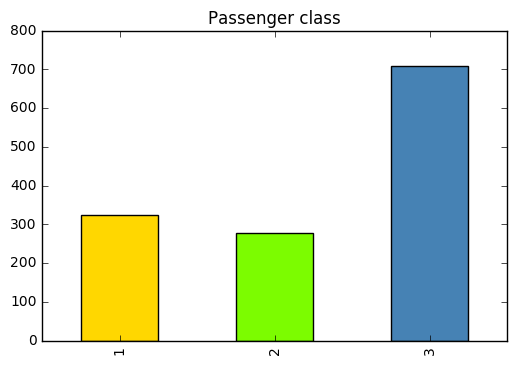

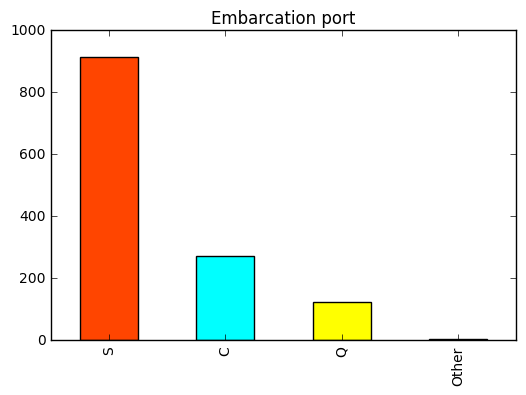

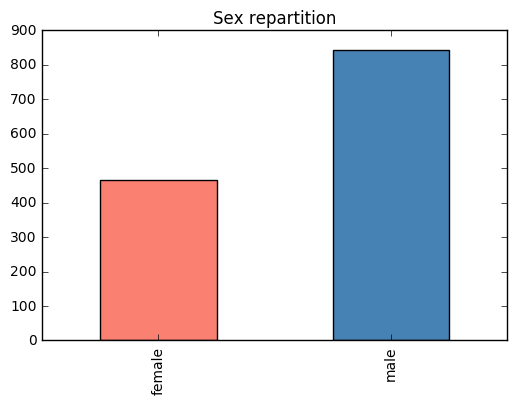

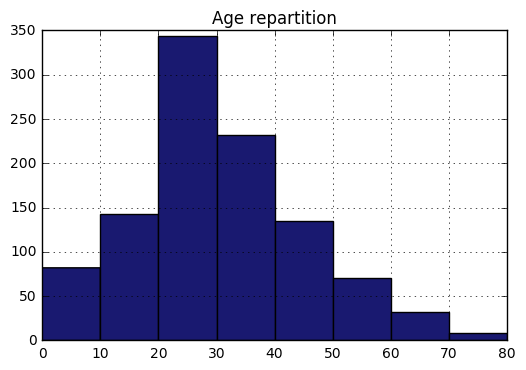

In [6]:
## 2

# Travel class
t_db['pclass'].value_counts().sort_index().plot(kind="bar", title="Passenger class", color=['gold','lawngreen','steelblue'])
plt.show()

# Embarcation port
t_db['embarked'].replace(np.nan, 'Other', regex=True).value_counts().plot(kind="bar", title="Embarcation port", color=['orangered','cyan','yellow','grey'])
plt.show()

# Sex
t_db['sex'].value_counts().sort_index().plot(kind="bar", title="Sex repartition", color=['salmon','steelblue'])
plt.show()

# Age
t_db['age'].hist(bins=[10*i for i in range(int(float(t_db.age.max())//10)+1)], color='midnightblue')
plt.title("Age repartition")
plt.show()

3-
For this question, we supposed that a floor= A,B,C,D,...

We get the floor by looking at the first letter in 'cabin'.

The data is not really relevant because there are many 'NaN'.

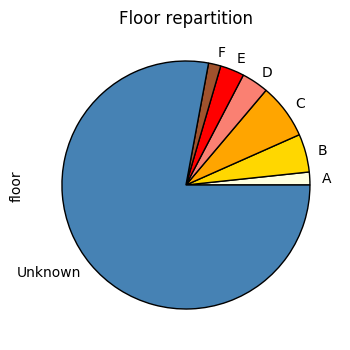

In [7]:
## 3-

# Create the attribute cabin floor
t_db['floor']=t_db.cabin.apply( lambda x : str(x)[0] if (str(x)[0] in ('A','B','C','D','E','F')) else 'Unknown')


# Do the pie chart
fig, ax = plt.subplots()
ax.set(aspect="equal")
t_db['floor'].value_counts().sort_index().plot(kind='pie',y='floor',colors=['lightyellow','gold','orange','salmon','red','sienna','steelblue']) 
plt.title("Floor repartition")
plt.show()

4-
Again, we use value_counts to get info with categorical attributes. 

We plot 3 graphs, each filtered by the class (1,2 or 3).


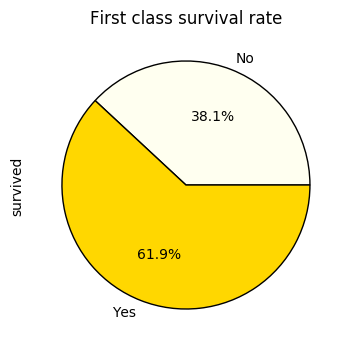

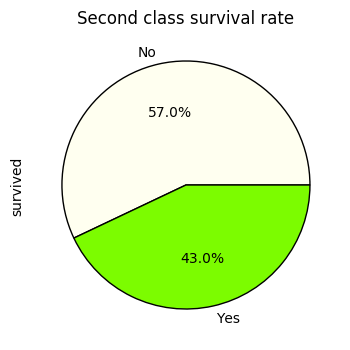

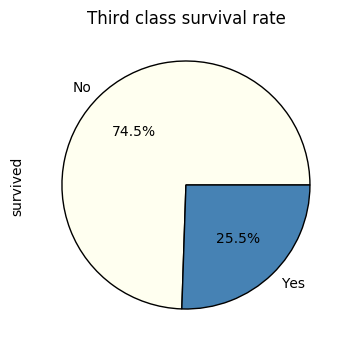

In [7]:
## 4-

# Get a circular pie chart
fig, ax = plt.subplots()
ax.set(aspect="equal")

t_db[t_db.pclass==1]['survived'].value_counts().sort_index().plot(kind='pie',y='survived',labels=['No','Yes'],colors=['ivory','gold'], autopct='%.1f%%') 
plt.title("First class survival rate")
plt.show()

# Get a circular pie chart
fig, ax = plt.subplots()
ax.set(aspect="equal")
t_db[t_db.pclass==2]['survived'].value_counts().sort_index().plot(kind='pie',y='survived',labels=['No','Yes'],colors=['ivory','lawngreen'], autopct='%.1f%%') 
plt.title("Second class survival rate")
plt.show()

# Get a circular pie chart
fig, ax = plt.subplots()
ax.set(aspect="equal")
t_db[t_db.pclass==3]['survived'].value_counts().sort_index().plot(kind='pie',y='survived',labels=['No','Yes'],colors=['ivory','steelblue'], autopct='%.1f%%') 
plt.title("Third class survival rate")
plt.show()

5-
We group by class and sex, and as an aggregate we use the fact that the mean of 0s and 1s gives a percentage to directly get the data.


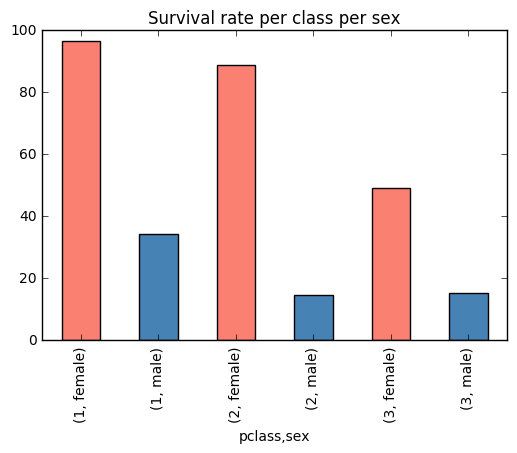

In [8]:
## 5-

t_db.groupby(['pclass','sex']).agg({'survived': lambda x : 100*x.mean()}).plot(kind="bar", title="Survival rate per class per sex", color=['salmon','steelblue'], legend=False)
plt.show()

6-
We create an age_group attribute, it can be 'Young' or 'Old' whether you are the first age category or in the second. To do so, we apply a parsing function to the age column.

The groupby is similar to question 5.

We reset the indices to get only one index.

In [9]:
## 6-

t_db['age_group']=t_db.age.apply( lambda x :'Young' if (x<t_db.age.mean()) else 'Old')
t_db.groupby(['age_group','pclass','sex']).agg({'survived': lambda x : 100*x.mean()}).reset_index()

,age_group,pclass,sex,survived
0,Old,1,female,97.029703
1,Old,1,male,30.555556
2,Old,2,female,86.363636
3,Old,2,male,8.695652
4,Old,3,female,47.572816
5,Old,3,male,11.718750
6,Young,1,female,95.348837
7,Young,1,male,48.571429
8,Young,2,female,90.322581
9,Young,2,male,21.518987
